# 1D benchmark

In this notebook, the result of 1D logitudinal CSR beam of a beam is benchmarked with the analytic solution from Murphy et al. (1997) paper. The input deck used is input/test_beam_remap.py. It is recommended to use enough simulation particles (e.g., 1e6) to reduce the noise in the field. The simulaton can be run with various choices of wavelet distribution, kernel and filter, please see the arguments of gen_test_wavelets function.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy import signal
from numpy import linalg 

import CosyrAnalyze 
import seaborn as sns

# plot setting 
mpl.rcParams['font.size'] = 12
mpl.rcParams["mathtext.default"] = "it"
mpl.rcParams['mathtext.fontset'] = 'cm'

#sns.plotting_context("poster")
sns.set_style("white")
#sns.axes_style({'font.family':'serif', 'font.serif':'Arial'})
sns.set_style({'font.family':'sans-serif', 'font.sans-serif':'Latin Modern Roman', "xtick.direction": "in","ytick.direction": "in"})
#print("Using following seaborn style:")
#print(sns.axes_style())

# Cosyr result analysis

## Load wavefronts and mesh

In [2]:
gamma = 1000
nalpha = 1001
nchi = 3
step = 1
particle_id = 0
ndirs = 0
R_bend = 1.0 # meter
beam_charge = 0.01*1e-9 #*1.6e-19  # Coulomb
N = beam_charge/1.6e-19  # number of real particles in the beam
axis_range = 600000.0
sigma = 200.0e-6/R_bend * gamma**3.0 / 6.0

beta = np.sqrt(1.0-gamma**(-2.0))

In [3]:
output_path = "../build/test_beam_remap_gradients/"
cosyr_1D_result=CosyrAnalyze.CosyrAnalyze(gamma, output_path, charge=beam_charge, pid=particle_id, step = step, load_data_all=0, wf_xy_rotate=0, )
cosyr_1D_result.load_wavefronts()
cosyr_1D_result.load_cmesh()

setting gamma to  1000
setting data_dir to  ../build/test_beam_remap_gradients/
setting charge to  1.0000000000000001e-11
setting R_bend to  1.0
setting pid to  0
setting step to  1
setting dt to  0.0001
setting traj_type to  2
setting load_data_all to  0
setting wf_xy_rotate to  0
setting wf_xy2polar to  0
setting p_beam to  None
setting self to  <CosyrAnalyze.CosyrAnalyze object at 0x12dae0130>


In [4]:
mesh_potential=cosyr_1D_result.cmesh_fld1.reshape([-1,nchi]).T[1,:]/N

mesh_fld=gamma**3.0*np.gradient(mesh_potential, axis_range/(mesh_potential.shape[0]-1))
mesh_fld_sm=signal.savgol_filter(mesh_fld, 51, 3)
mesh_fld_remap=cosyr_1D_result.cmesh_fld1_dx.reshape([-1,nchi]).T[1,:]/N
mesh_fld_remap_sm=signal.savgol_filter(mesh_fld_remap, 51, 3)
alpha_axis = np.linspace(-axis_range/2.0, axis_range/2.0, mesh_potential.shape[0])


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


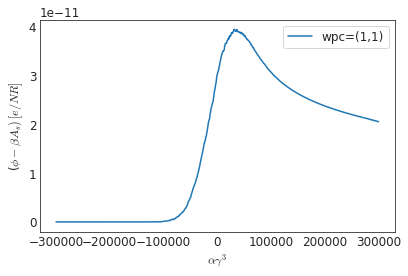

In [5]:
plt.figure()
plt.plot(alpha_axis, mesh_potential, label="wpc=(1,1)")
plt.xlabel(r"$\alpha \gamma^{3}$")
plt.ylabel(r"($\phi - \beta A_s) \, [e/NR]$")
plt.legend()
plt.tight_layout()

## Comparison with analytic result from parabolic cylinder function (for Gaussian beam only)

In [6]:
# Note: scipy parabolic cylinder function sometimes leads to kernel crash, especially if axis range is too large
x = alpha_axis/sigma
parabolic_cylinder_func = scipy.special.pbdv(1.0/3.0, -x) 
temp=parabolic_cylinder_func[0].copy()
analytic_beam_fld = temp*np.exp(-x**2.0/4.0)*scipy.special.gamma(2.0/3.0) 

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


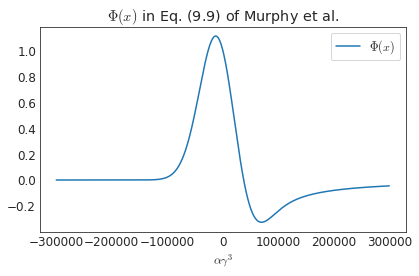

In [7]:
plt.figure()
plt.clf()
plt.plot(alpha_axis, analytic_beam_fld, label=r"$\Phi(x)$")
plt.xlabel(r"$\alpha \gamma^{3}$")
plt.title(r"$\Phi(x)$ in Eq. (9.9) of Murphy et al.")
plt.legend(loc="upper right")
plt.tight_layout()

In [8]:
# Eq. (9.8) in Murphy 1997 paper, in unit of e*gamma^4/R^2, averaged for each particle (i.e., beam of chagre e)
analytic_beam_fld *= np.sqrt(2.0/np.pi)/(3.0*(sigma/gamma**3.0/R_bend)**4.0)**(1.0/3.0)/gamma**4.0

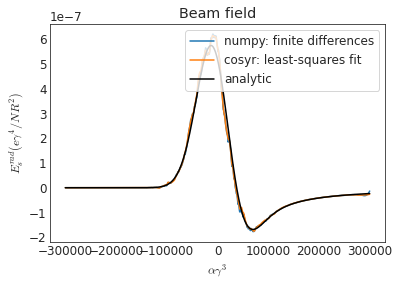

In [14]:
plt.figure()
plt.plot(alpha_axis,mesh_fld_sm, label="numpy: finite differences")
plt.plot(alpha_axis,mesh_fld_remap_sm, label="cosyr: least-squares fit")
plt.plot(alpha_axis, analytic_beam_fld, "k-", label="analytic")
plt.xlabel(r"$\alpha \gamma^{3}$")
plt.ylabel(r"$E_{s}^{rad} (e \gamma^4/NR^2)$")
plt.title("Beam field")
plt.legend(loc="upper right")
#plt.tight_layout()

In [15]:
# L2 norm
print("numpy: finite differences: L2 norm =", linalg.norm(analytic_beam_fld-mesh_fld_sm))
print("cosyr: least-squares fit:  L2 norm =", linalg.norm(analytic_beam_fld-mesh_fld_remap_sm))

numpy: finite differences: L2 norm = 4.458143749750236e-07
cosyr: least-squares fit: L2 norm = 4.405185084880268e-07
